In [1]:
# !pip install transformers

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB
import torch
import transformers as ppb
import warnings
import mlxtend
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('malayalam_testGOLD.tsv', delimiter='\t', header=None)
df.head()

,0,1
0,nourin sk yantukond,0
1,voice ullup illa daaa tayoli ath kond alle nin...,0
2,angana parayalle broo,0
3,aswathi priya hai,0
4,vyas deep ningal enthinod enthineyanu connect ...,0


In [3]:
# pip install torch

In [4]:
batch_1 = df[:2000]
batch_1

,0,1
0,nourin sk yantukond,0
1,voice ullup illa daaa tayoli ath kond alle nin...,0
2,angana parayalle broo,0
3,aswathi priya hai,0
4,vyas deep ningal enthinod enthineyanu connect ...,0
...,...,...
424,pubg korean aanu,0
425,aarum parayunnath ningal kelkkanda ningal jeev...,1
426,marzelo op ath vedich poyille broopullikkaran ...,0
427,ninnu chelakkathe cheithu kaanikk ennale kalip...,0


In [5]:
batch_1[1].value_counts()

0    363
1     66
Name: 1, dtype: int64

In [6]:
batch_1[1].value_counts()

0    363
1     66
Name: 1, dtype: int64

In [14]:
# For DistilBERT:
model_class, tokenizer_class, pretrained_weights = (ppb.DistilBertModel, ppb.DistilBertTokenizer, 'distilbert-base-uncased')

## Want BERT instead of distilBERT? Uncomment the following line:
#model_class, tokenizer_class, pretrained_weights = (ppb.BertModel, ppb.BertTokenizer, 'bert-base-uncased')

# Load pretrained model/tokenizer
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [15]:
df.head()

,0,1
0,nourin sk yantukond,0
1,voice ullup illa daaa tayoli ath kond alle nin...,0
2,angana parayalle broo,0
3,aswathi priya hai,0
4,vyas deep ningal enthinod enthineyanu connect ...,0


In [16]:
tokenized = batch_1[0].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))

In [17]:
max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)

padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])

In [18]:
np.array(padded).shape

(429, 205)

In [19]:
attention_mask = np.where(padded != 0, 1, 0)
attention_mask.shape

(429, 205)

In [20]:
input_ids = torch.tensor(padded)  
attention_mask = torch.tensor(attention_mask)

with torch.no_grad():
    last_hidden_states = model(input_ids, attention_mask=attention_mask)

In [21]:
features = last_hidden_states[0][:,0,:].numpy()

In [22]:
labels = batch_1[1]

In [23]:
train_features, test_features, train_labels, test_labels = train_test_split(features, labels)

In [24]:
#LogisticRegression  

In [25]:
lr_clf = LogisticRegression()
lr_clf.fit(train_features, train_labels)

LogisticRegression()

In [26]:
lr_clf.score(test_features, test_labels)

0.8518518518518519

In [27]:
y_predL = lr_clf.predict(test_features)

In [28]:
from sklearn.dummy import DummyClassifier
clf = DummyClassifier()

scores = cross_val_score(clf, train_features, train_labels)
print("Dummy classifier score: %0.3f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Dummy classifier score: 0.835 (+/- 0.01)




confusion matrix


[[91  4]
 [12  1]]




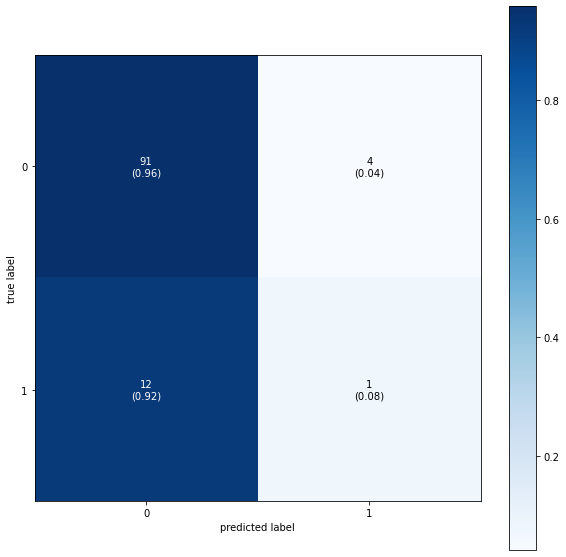

In [29]:
from sklearn.metrics import classification_report, confusion_matrix
from mlxtend.plotting import plot_confusion_matrix


print('\n')
print("confusion matrix")
print('\n')
CR=confusion_matrix(test_labels, y_predL)
print(CR)
print('\n')

fig, ax = plot_confusion_matrix(conf_mat=CR,figsize=(10, 10),
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True)
plt.show()

In [35]:
# pip install mlxtend

In [36]:
#     kfold validation

In [37]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=10)
kf

KFold(n_splits=10, random_state=None, shuffle=False)

In [38]:
for train_index, test_index in kf.split('malayalam_testGOLD.tsv'):
    print(train_index, test_index)

[ 3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21] [0 1 2]
[ 0  1  2  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21] [3 4 5]
[ 0  1  2  3  4  5  8  9 10 11 12 13 14 15 16 17 18 19 20 21] [6 7]
[ 0  1  2  3  4  5  6  7 10 11 12 13 14 15 16 17 18 19 20 21] [8 9]
[ 0  1  2  3  4  5  6  7  8  9 12 13 14 15 16 17 18 19 20 21] [10 11]
[ 0  1  2  3  4  5  6  7  8  9 10 11 14 15 16 17 18 19 20 21] [12 13]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 16 17 18 19 20 21] [14 15]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 18 19 20 21] [16 17]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 20 21] [18 19]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19] [20 21]


In [39]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.datasets import load_digits
digits = load_digits()

def get_score(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    return model.score(X_test, y_test)

In [40]:
from sklearn.model_selection import StratifiedKFold
folds = StratifiedKFold(n_splits=10)

scores_logistic = []
#scores_svm = []
#scores_rf = []

for train_index, test_index in folds.split(digits.data,digits.target):
    X_train, X_test, y_train, y_test = digits.data[train_index], digits.data[test_index], \
                                       digits.target[train_index], digits.target[test_index]
    scores_logistic.append(get_score(LogisticRegression(solver='liblinear',multi_class='ovr'), X_train, X_test, y_train, y_test))  
    #scores_svm.append(get_score(SVC(gamma='auto'), X_train, X_test, y_train, y_test))
    #scores_rf.append(get_score(RandomForestClassifier(n_estimators=40), X_train, X_test, y_train, y_test))

In [41]:
scores_logistic

[0.9111111111111111,
 0.9388888888888889,
 0.8944444444444445,
 0.8666666666666667,
 0.9444444444444444,
 0.9722222222222222,
 0.9777777777777777,
 0.9497206703910615,
 0.8603351955307262,
 0.9441340782122905]

In [42]:
#Grid Search with Logistic Regression

In [43]:
import numpy as np # linear algebra
import pandas as pd

In [44]:
from sklearn.datasets import load_iris
iris=load_iris()

x=iris.data
y=iris.target

x=x[:100,:]#first 100
y=y[:100]# first 100
# normalization
x=(x-np.min(x))/(np.max(x)-np.min(x))

In [45]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test=train_test_split(x,y,test_size=0.3)

In [46]:
# Grid search cross validation
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
grid={"C":np.logspace(-3,3,7), "penalty":["l1","l2"]}# l1 lasso l2 ridge
logreg=LogisticRegression()
logreg_cv=GridSearchCV(logreg,grid,cv=10)
logreg_cv.fit(test_features, test_labels)

print("tuned hpyerparameters :(best parameters) ",logreg_cv.best_params_)
print("accuracy :",logreg_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'C': 0.001, 'penalty': 'l2'}
accuracy : 0.8800000000000001


In [47]:
logreg2=LogisticRegression(C=1,penalty="l2")
logreg2.fit(test_features, test_labels)
print("score",logreg2.score(test_features, test_labels))

score 0.9351851851851852
